# Getting stared with FastAI v1: Tabular data

This notebook illustrates how to get started with FastAI v1 for Tabular Data. The notebook will focus on introducing the API to newcomers, with an overview, including installation instructions for FastAI v1, given at: https://www.avanwyk.com/getting-started-with-fastai-v1-tabular-data/.

The details of the deep learning techniques used (such as embedding, learning rate cycles etc.) are not covered in this notebook. For a detailed description of the techniques used, have a look at this blog post: [http://www.fast.ai/2018/04/29/categorical-embeddings/](http://www.fast.ai/2018/04/29/categorical-embeddings/).

FastAI provides a convenient way of importing a lot of commonly used modules, including Numpy and Pandas: 

In [ ]:
from fastai import *
from fastai.tabular import *

from sklearn.model_selection import train_test_split

np.set_printoptions(precision=4, suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Data Loading

Before getting to the FastAI model, we first have to prepare our data. The dataset can be download here: https://www.kaggle.com/cdc/mortality. Download the data and place it into a directory `data`. We will be attempting to predict the age of mortaility using basic demographic data. The Kaggle data is separated into CSV files by year. We will limit the data to two year's worth, simply for performance reasons. We load the yearly data in turn and then create a single dataframe containing all the data.

In [ ]:
data_path = Path('data')

In [ ]:
frames = []

for year in range(2005, 2007):
    frames.append(pd.read_csv(data_path/f'{year}_data.csv'))
    
df = pd.concat(frames)

/home/avanwyk/anaconda/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (39,40,41,42,43,44,45,46,47,59,60,61,62,63,64,65,66) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/avanwyk/anaconda/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (39,40,41,42,43,44,45,46,47,59,60,61,62,63,64,65,66,67) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The data contains 77 different columns (info into the meaning of the fields can be found [here](https://www.cdc.gov/nchs/nvss/mortality_public_use_data.htm)), however, we are only interested in the demographic data for this experiment, so we discard the other columns.


In [ ]:
demographic_colums = ['resident_status', 'education_1989_revision', 'education_2003_revision', 'education_reporting_flag', 'sex',
                      'detail_age_type', 'detail_age', 'marital_status', 'race']

In [ ]:
df = df.filter(demographic_colums)

In [ ]:
df.sample(5)

,resident_status,education_1989_revision,education_2003_revision,education_reporting_flag,sex,detail_age_type,detail_age,marital_status,race
648565,2,99.000,nan,0,M,1,66,D,2
2383145,2,nan,1.000,1,M,1,62,M,1
171117,1,nan,6.000,1,F,1,68,M,1
960800,1,12.000,nan,0,F,1,70,W,1
1975305,1,nan,1.000,1,M,1,74,M,1


### Data Pre-processing

The educational level is reported based on one of two systems: the 1989 revision and the 2003 revision. Here we normalize the education level to a single standard. We translate both revision's data to new categories which roughly groups similar categories from the other revision systems.

category | description (highest level of education)
--- | ---
P | some primary school or no education
H | some high school education
T | some tertiary education
U | unknown

In [ ]:
def normalize_education(frame):
    frame['education'] = 'U'
    
    filter_1989 = frame['education_reporting_flag'] == 0
    
    frame.loc[filter_1989 & (frame.education_1989_revision <= 8.0), 'education'] = 'P'
    frame.loc[filter_1989 & (frame.education_1989_revision > 8.0) & (frame.education_1989_revision <= 12.0), 'education'] = 'H'
    frame.loc[filter_1989 & (frame.education_1989_revision > 12.0) & (frame.education_1989_revision < 99.0), 'education'] = 'T'
    frame.loc[filter_1989 & ((frame.education_1989_revision >= 99.0) | (frame.education_1989_revision.isna())), 'education'] = 'U'
    
    filter_2003 = frame['education_reporting_flag'] == 1
    frame.loc[filter_2003 & (frame.education_2003_revision <= 1), 'education'] = 'P'
    frame.loc[filter_2003 & (frame.education_2003_revision > 1) & (frame.education_2003_revision <= 3.0), 'education'] = 'H'
    frame.loc[filter_2003 & (frame.education_2003_revision > 3) & (frame.education_2003_revision < 9), 'education'] = 'T'
    frame.loc[filter_2003 & ((frame.education_2003_revision == 9) | (frame.education_2003_revision.isna())), 'education'] = 'U'
    return frame

Similarly we have to normalize the age: we treat any death before 12 months as 1 year.

In [ ]:
def normalize_age(frame):
    frame['age'] = np.nan
    
    less_than_12_months = (frame['detail_age_type'] > 1) & (frame['detail_age_type'] < 9)
    age_in_years = frame['detail_age_type'] == 1
    unknown_age = frame['detail_age_type'] == 9
    
    frame.loc[less_than_12_months, 'age'] = 1
    frame.loc[age_in_years, 'age'] = frame[age_in_years].detail_age
    frame.loc[unknown_age, 'age'] = np.nan
    
    return frame

In [ ]:
df = normalize_education(df)
df = normalize_age(df)

In [ ]:
df.describe()

,resident_status,education_1989_revision,education_2003_revision,education_reporting_flag,detail_age_type,detail_age,race,age
count,4883231.000,2743015.000,2140216.000,4883231.000,4883231.000,4883231.000,4883231.000,4882579.000
mean,1.220,17.979,3.401,0.438,1.035,72.567,1.562,72.311
std,0.495,23.265,1.841,0.496,0.360,22.565,4.767,18.989
min,1.000,0.000,1.000,0.000,1.000,0.000,1.000,1.000
25%,1.000,10.000,2.000,0.000,1.000,63.000,1.000,63.000
50%,1.000,12.000,3.000,0.000,1.000,77.000,1.000,77.000
75%,1.000,14.000,4.000,1.000,1.000,86.000,1.000,86.000
max,4.000,99.000,9.000,1.000,9.000,999.000,78.000,125.000


We can see in the dataframe description that some of the age values are missing. For the sake of simplity we can drop those rows.

In [ ]:
df['age'] = df['age'].astype(np.float32)

In [ ]:
df = df.dropna(subset=['age'])

In [ ]:
df.sample(5)

,resident_status,education_1989_revision,education_2003_revision,education_reporting_flag,sex,detail_age_type,detail_age,marital_status,race,education,age
1391239,1,nan,3.000,1,M,1,90,W,1,H,90.000
145995,1,nan,6.000,1,F,1,92,W,1,T,92.000
1087660,1,12.000,nan,0,F,1,74,W,1,H,74.000
2362235,1,12.000,nan,0,F,1,86,W,1,H,86.000
1832611,1,12.000,nan,0,M,1,84,W,2,H,84.000


## FastAI

Our data is now ready for us to train the model. We won't be using all the columns (as some columns are simply flags indicating the type of another column). So we discard all the columns we don't need. We also split or training data into a training and validation dataset.

In [ ]:
df_fastai = df[['resident_status', 'education', 'sex', 'marital_status', 'race', 'age']]

In [ ]:
df_fastai.sample(5)

,resident_status,education,sex,marital_status,race,age
2377379,1,T,M,M,1,78.000
742113,1,H,F,S,2,51.000
1133126,1,H,F,W,1,71.000
1199708,2,H,F,S,1,15.000
107649,1,P,M,M,1,68.000


In [ ]:
train_df, valid_df = train_test_split(df_fastai, test_size=0.33)

The FastAI API requires us to define the dependent variable, which is the variable we are trying to predict. This is `age` in our case. Further, we need to specify the categorical columns by name such that FastAI can automatically handle them for us (more on this below).

In [ ]:
dep_var = 'age'
categorical_names = ['education', 'sex', 'marital_status']

tfms = [FillMissing, Categorify]

Notice how we also define to transformations: `FillMissing` and `Categorify`.

The `FillMissing` transform will fill in any missing values for the _continuous_ variable columns we have using the median to do so (by default). Read more about the transformer [here](http://docs.fast.ai/tabular.transform.html#class-fillmissing).

The `Categorify` transformation will take categorical data, automatically assign ids to each of the unqiue values and replace the column values with the ids. A special id is used for missing values. Read more about the transformer [here](http://docs.fast.ai/tabular.transform.html#class-fillmissing).

We can now setup a [Tabular Dataset](http://docs.fast.ai/tabular.data.html#TabularDataset) for training.  In addition to applying the transformations above the `TabularDataset` will also *normalize* the continuous variables for us.

In [ ]:
tabular_data = tabular_data_from_df('output', train_df, valid_df, dep_var, tfms=tfms, cat_names=categorical_names)

/home/avanwyk/anaconda/envs/fastai/lib/python3.6/site-packages/fastai/tabular/transform.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[n] = df[n].astype('category').cat.as_ordered()
/home/avanwyk/anaconda/envs/fastai/lib/python3.6/site-packages/fastai/tabular/transform.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[n] = pd.Categorical(df[n], categories=self.categories[n], ordered=True)


### Model

We are now ready to create a [TabularModel](http://docs.fast.ai/tabular.models.html#class-tabularmodel). TabularModels are relatively simple models that have Embedding layers for each of the categorical variables which are concatenated with the continuous layers before being passed to a fully connected layers. The model also includes Dropout and Batchnorm layers where expected (see below for detailed depiction of the layers).

In our case we use 2 fully connected layers of dimension 100. Since we are doing regression, we then have an output layer of a single dimension (which will automatically have a Linear activation) and we use a mean squared error loss function. We also specify embedding layer sizes for the two categorical layers.

In [ ]:
learn = get_tabular_learner(tabular_data,
                            layers=[100,50,1],
                            emb_szs={'education': 6,
                                     'sex': 5,
                                     'marital_status': 8})
learn.loss_fn = F.mse_loss

The code below outputs a detailed description of the model:

In [ ]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(5, 6)
    (1): Embedding(3, 5)
    (2): Embedding(6, 8)
  )
  (emb_drop): Dropout(p=0.0)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=21, out_features=100, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=100, out_features=50, bias=True)
    (4): ReLU(inplace)
    (5): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=50, out_features=1, bias=True)
    (7): ReLU(inplace)
  )
)

Finally, before starting training, we need to choose an appropriate learning rate. FastAI provides an extremely neat trick for finding an appropriate learning rate. See [here](http://docs.fast.ai/callbacks.lr_finder.html) and [here](https://arxiv.org/abs/1506.01186) for details.

Applying the method is very straightfoward:

In [ ]:
learn.lr_find()

After running `lr_find()` we can plot the losses against the learning rates that were tried:

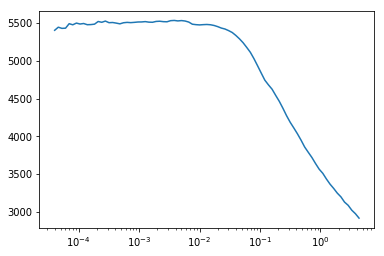

In [ ]:
learn.recorder.plot()

We then choose a value that is smaller (FastAI recommends by an order of magnitude) than the point at which the loss explodes. In our case there is not increase in loss even for large learning rates, so we could try even bigger start and stop values for lr find.. For now, we will use `1e-1`.

In [ ]:
lr = 1e-1

We can now train our model. FastAI supports training with [cyclical learning rates](http://docs.fast.ai/callbacks.one_cycle.html#OneCycleScheduler) (the only deep learning libary to do so out of the box), which is used when we call the `fit_one_cycle` method. Here we perform a single epoch of training:

In [ ]:
learn.fit_one_cycle(1, lr)

Total time: 04:39
epoch  train loss  valid loss
0      214.174057  218.020081  (04:39)



Great! Now we have a trained model, although it definitely seems to be overfitting on our data. The `recorder` records a lot of training data for us. For example, we can easily plot our loss per iterations:

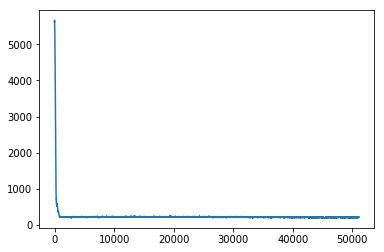

In [ ]:
learn.recorder.plot_losses()

Our learning rate helped a lot, as we can see, the network converged very early in the training.

We can now continue training with smaller learning rates if we wanted to and attempt to find a better minima.

### Random Forest Baseline

As shown [here](https://gist.github.com/dienhoa/a5adf923bd8b24b3d0eadcd61aec8c2e), we can re-use the FastAI datasets (and pre-processing) to build training data for other algorithms. For example, here we build a training and validation set for a random forest regressor to use a baseline for our DNN.

In [ ]:
def get_arrays(ds):
    X_cats,X_conts = ds.cats.numpy(), ds.conts.numpy()
    y = ds.y.numpy()
    return np.concatenate((X_cats, X_conts), axis=1), y

In [ ]:
X_train, y_train = get_arrays(tabular_data.train_ds)

In [ ]:
X_val, y_val = get_arrays(tabular_data.valid_ds)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

rf.fit(X_train,y_train)

rf.score(X_val, y_val)

/home/avanwyk/anaconda/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.43072695674825656

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_val, rf.predict(X_val))

204.51403268746253

Seems like we have some work to do to optimize our network. Likely we can simply tune our learning rate decay to use a much smaller learning rate near the end of the epoch.

## References
Please have a look at the excellent FastAI docs for a detailed overview of the API: http://docs.fast.ai. 

The FastAI forums are also worth mentioning, it's one of the most active and inclusive Deep Learning forums out there: http://forums.fast.ai